<a href="https://colab.research.google.com/github/Bani-Talebi/Electricity-Price-Forecasting/blob/master/DA_EPF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Introduction
In this notebook a timeseries model is developed to predict Day-Ahead electricity prices for the Ontario electricity market. The input data is taken from the IESO website and contains all hourly market clearing prices from first January 2010, until December 31, 2019. The model uses the historical timeseries data to extract common temporal patterns of electricity prices.

The output prediction of the model will span all 24 hourly intervals of the next day, using only information that is available prior to Day-Ahead market closing time at 12:00 h of the current day.

**Contents**

*   Step 1: Preprocess the data
*   Step 2: Set up benchmark models
*   Step 3: Design the model architecure
*   Step 4: Finetune the model

The first step explores the dataset and, if necessary, preprocess the data to better fit our prediction model. In order to have a sufficient benchmark for all of hour modeling approaches, a benchmark solution is defined that serves as a foundation to compare our efforts against. After that, we will design and finetune a neural network to predict prices on the Day-Ahead market.

In [ ]:
import seaborn as sns
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import pandas as pd
from google.colab import files
import matplotlib
def plot_average_prices(data):
    
    """Plot monthly, daily and hourly averages of input data."""
    plt.rcParams['font.family']='STIXGeneral'
    plt.rcParams['font.size']=8
    plt.rcParams['figure.autolayout']=True
    plt.rcParams['axes.titlesize']=8
    plt.rcParams['axes.labelsize']=6
    plt.rcParams['lines.linewidth']=1
    plt.rcParams['lines.markersize']=2
    plt.rcParams['legend.fontsize']=8
    plt.rcParams['mathtext.fontset']='stix'
    plt.rcParams['mathtext.fontset']='custom'
    plt.rcParams['legend.numpoints']=1

    #f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(3.5,2.8), sharey=True)
    
    fig = plt.figure(figsize=(3.5,2.8))
    #fig = plt.figure()
    ax1 = fig.add_subplot(311)
    ax2 = fig.add_subplot(312)
    ax3 = fig.add_subplot(313)


    data.groupby(data.index.month).mean().plot.bar(ax=ax1)
    #ax1.set_title('Monthly Average')
    ax1.set_ylabel('Price ($/MWh)')
    ax1.set_xlabel('Month of the year')
    data.groupby(data.index.dayofweek).mean().plot.bar(ax=ax2)
    #ax2.set_title('Weekly Average')
    ax2.set_ylabel('Price ($/MWh)')
    ax2.set_xlabel('Day of the week')
    data.groupby(data.index.hour).mean().plot.bar(ax=ax3)
    #ax3.set_title('Hourly Average')
    ax3.set_ylabel('Price ($/MWh)')
    ax3.set_xlabel('Hour of the day')
    matplotlib.rc('axes',edgecolor='black')

    #plt.savefig('Time_Effect.pdf',dpi=300)
    #files.download('Time_Effect.pdf')
    
def replace_outliers(data, column, tolerance):

    """Replace outliers out of 75% + tolerance * IQR or 25% - tolerance * IQR by these thresholds"""
    
    tol = tolerance
    data_prep = data.copy(deep=True)
    
    # calculate quantiles and inter-quantile range of the data
    q75 = data_prep[column].quantile(.75)
    q25 = data_prep[column].quantile(.25)
    IQR = q75 - q25

    # values larger (smaller) than q75 (q25) plus 'tol' times IQR get replaced by that value
    data_prep[column] = data_prep[column].apply(lambda x: q75 + tol * IQR if (x > q75 + tol * IQR) else x)
    data_prep[column] = data_prep[column].apply(lambda x: q25 - tol * IQR if (x < q75 - tol * IQR) else x)
    
    return data_prep

In [ ]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.externals import joblib
import seaborn as sns
sns.set_style('white')

/usr/local/lib/python3.7/dist-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


In [ ]:

up=files.upload()



Saving HOEP.csv to HOEP.csv


In [ ]:
# load the historical Day-Ahead price data
df = pd.read_csv('HOEP.csv',index_col=0, parse_dates=True)
df.index=pd.date_range('2010-01-01',periods=87648,freq='H')
df.drop(columns=['Hour'],inplace=True)
df.head()

,HOEP
2010-01-01 00:00:00,33.83
2010-01-01 01:00:00,27.49
2010-01-01 02:00:00,25.96
2010-01-01 03:00:00,27.20
2010-01-01 04:00:00,28.50


In [ ]:
df.tail()

,HOEP
2019-12-31 19:00:00,0.00
2019-12-31 20:00:00,0.00
2019-12-31 21:00:00,-0.05
2019-12-31 22:00:00,-0.04
2019-12-31 23:00:00,-0.02



# **1. Preprocess the data**

In [ ]:
da_raw=df
# check if their are any gaps within the data
any(da_raw.dropna().index.to_series().diff() > pd.Timedelta('01:00:00'))

False

In [ ]:
A=da_raw.describe()
Q3=A['HOEP']['75%']
Q1=A['HOEP']['25%']
IQR=Q3-Q1
d1=Q1-1.7*IQR
d2=Q3+1.7*IQR
s=0
for i in range(len(da_raw)):
  if da_raw['HOEP'].iloc[i]<d1 or da_raw['HOEP'].iloc[i]>d2:
    s+=1
s/len(da_raw)*100

2.943592552026287

In [ ]:
A

,HOEP
count,87648.000000
mean,23.641280
std,29.923413
min,-138.790000
25%,10.160000
50%,21.880000
75%,32.430000
max,1822.950000



**Outliers**

While the majority of the price data seems lies within a price range of 11 - 33 CAD/MWh, the maximum and minimum prices of 1822.95 CAD/MWh and -138.79 CAD/MWh constitute significant outliers. Since we are mainly interested to find out a general temporal pattern, these outliers are really undesirable. Moreover, they will screw up each attempt of min-max scaling the data. The outliers will determine the 0- and 1-equivalents of the new scale while most of the data corpus will lie within a very small range without much variation in between 'common' samples as a result.

We can see that there are extreme price peaks in the historical data. These extreme prices should be removed to avoid problems when scaling the data to a range between 0 and 1. Scaling is essential for the purpose of this work which plans on using a neural network for prediction. Neural networks generally benefit from feature scaling.

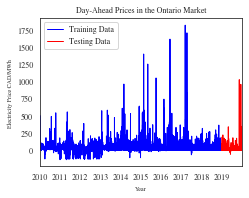

In [ ]:
# plot the price full price data set
plt.rcParams['font.family']='STIXGeneral'
plt.rcParams['font.size']=8
plt.rcParams['figure.autolayout']=True
plt.rcParams['axes.titlesize']=8
plt.rcParams['axes.labelsize']=6
plt.rcParams['lines.linewidth']=1
plt.rcParams['lines.markersize']=2
plt.rcParams['legend.fontsize']=8
plt.rcParams['mathtext.fontset']='stix'
plt.rcParams['mathtext.fontset']='custom'
plt.rcParams['legend.numpoints']=1

ax = da_raw['HOEP'][:'2018'].plot(figsize=(3.5, 2.8), color='blue', label='Training Data')
ax = da_raw['HOEP']['2019'].plot(figsize=(3.5, 2.8),color='red', label='Testing Data')
ax.legend()
ax.set_ylabel('Electricity Price CAD/MWh')
ax.set_title('Day-Ahead Prices in the Ontario Market')
ax.set_xlabel('Year');
#plt.savefig('HOEP.pdf',dpi=300)
#files.download('HOEP.pdf')

**Time and Date Effect**

Before actually preprocessing the data, let's have a quick look at the general distribution of the data, especially with respect to any patterns that are identifiable with pure visualization. Followings are the plots of average price for all months, weekdays and hours in the dataset.

It seems that electricity price has some very obvious temporal patterns. Electricity is cheaper in summer than in winter. While electricity costs most during workdays, it drops towards the weekend with lowest prices on Sunday. Over the course of a day, electricity is cheapest after midnight, peaks in the morning and evening hours and is a little lower during working hours. Those are very superficial analyses of temporal patterns, but it is obvious that there are some patterns available, that we should be able to extract from the data.

In the next steps, I will preprocess the data for training. Since we need real, unprocessed data as a sufficient baseline for evaluating the model performance, I keep an untouched copy of data (all prices of 2019) as a test set for evaluation purposes

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

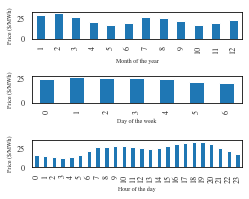

In [ ]:
# aggregate and average dat with respect to filter criterion and plot results
plot_average_prices(da_raw['HOEP']);
plt.savefig('Time_Effect.png',dpi=300)
files.download('Time_Effect.png')

In [ ]:
# keep raw data of the test set for model evaluation
test_raw = da_raw['2019']


# **1.1 Remove outliers**
As shown above, our data includes some significant outliers that might be detrimental for our intentions. We will apply a quite aggressive outlier removal and replace values that are outside the 2 x interquartile range of the 25% and 75% quantiles with the respective quantiles.

In [ ]:
# replace outliers by outlier threshold
da_prep = replace_outliers(da_raw, 'HOEP', 1.7)


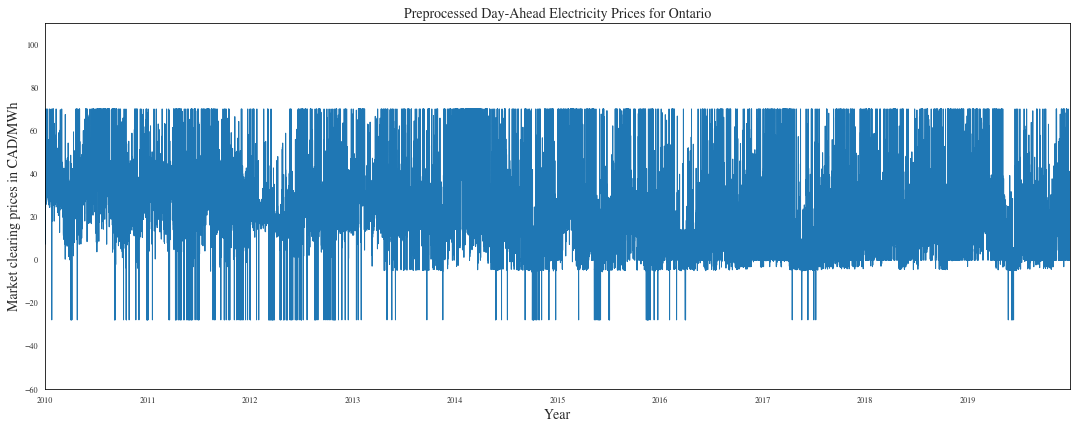

In [ ]:

# plot the results
ax = da_prep['HOEP'].plot(figsize=(15, 6))
ax.set_ylabel('Market clearing prices in CAD/MWh', fontsize=14)
ax.set_xlabel('Year', fontsize=14)
ax.set_title('Preprocessed Day-Ahead Electricity Prices for Ontario', fontsize=14)
ax.set_ylim((-60, 110));


**Preprocessed Data**

The range of the prices now looks much more appropriate to be scaled to 0-1 values. When scaling, the data will now be much more spread out instead of concentrating around some median value, as it would have been the case when the outliers would not have been removed. The histogram below shows the distribution of prices for which outliers have been replaced.

Text(0.5, 0, 'Electricity Price CAD/MWh')

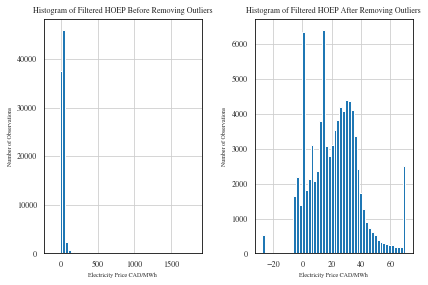

In [ ]:
f, (ax1,ax2) = plt.subplots(1,2)
da_raw['HOEP'].hist(bins=50,ax=ax1)
ax1.set_title('Histogram of Filtered HOEP Before Removing Outliers')
ax1.set_ylabel('Number of Observations')
ax1.set_xlabel('Electricity Price CAD/MWh')

da_prep['HOEP'].hist(bins=50,ax=ax2)
ax2.set_title('Histogram of Filtered HOEP After Removing Outliers')
ax2.set_ylabel('Number of Observations')
ax2.set_xlabel('Electricity Price CAD/MWh')
#plt.savefig('PriceHistogram.png',dpi=300)
#files.download('PriceHistogram.png')

# **1.2 Scaling and rearranging the data**
I use a sklearn.MinMaxScaler to scale the data to a range of 0-1

In [ ]:
# scale data to range between 0 and 1
da_scaler = MinMaxScaler()
da_prep['HOEP'] = da_scaler.fit_transform(da_prep['HOEP'].values.reshape(-1, 1))


**Explanation**

The model is fed with historical timeseries data. In order to predict the next 24 hours of a single day, it requires historical price values for the last $n$ hours prior to this day. This logic has to be represented by the strucutre of the data we feed into the model. For a better intuitive understanding, see the figure below. The blue part of the data will serve as input, a set of features, for predicting the red part of the line. The input is a vector of historical prices, the output a vector of prices for the upcoming day, one entry per hour.

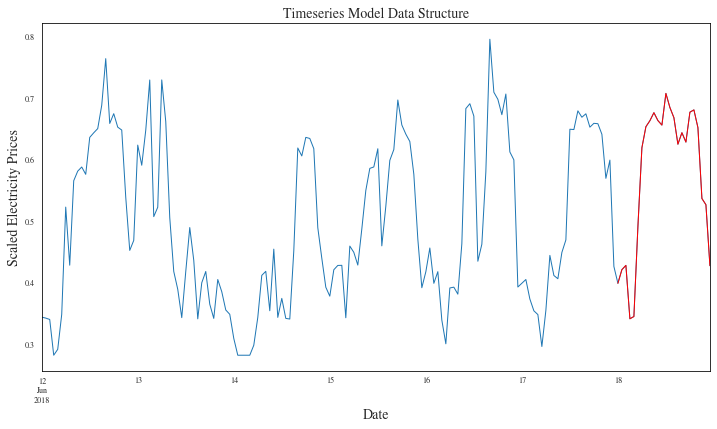

In [ ]:
feature_data = da_prep.loc['2018-06-12':'2018-06-18', 'HOEP']
feature_data.columns = ['input data']
label_data = da_prep.loc['2018-06-18', 'HOEP']
label_data.columns = ['data to predict']
f, ax = plt.subplots(figsize=(10, 6))
feature_data.plot(ax=ax)
label_data.plot(ax=ax, color='red')
ax.set_ylabel('Scaled Electricity Prices', fontsize=14)
ax.set_xlabel('Date', fontsize=14)
ax.set_title('Timeseries Model Data Structure', fontsize=14);


In order to achieve that structure the data has to be 'lagged'. This can be achieved by adding columns to every row of the input data, one column for each lagged value. In order to use the last week hourly price data, we have to lag for 7x24=168 hours.

In [ ]:
# include time lags of timeseries data for 1 week = 7 * 24h = 168h
lags = 168
for l in range(1, lags+1):
    da_prep['l_{}'.format(l)] = da_prep['HOEP'].shift(l)

In [ ]:
# drop missing data entries that result from the lagging step (no lagged data available for first 168 days of year)
da_prep.dropna(inplace=True)
da_prep.head(n=5)

,HOEP,l_1,l_2,l_3,l_4,l_5,l_6,l_7,l_8,l_9,l_10,l_11,l_12,l_13,l_14,l_15,l_16,l_17,l_18,l_19,l_20,l_21,l_22,l_23,l_24,l_25,l_26,l_27,l_28,l_29,l_30,l_31,l_32,l_33,l_34,l_35,l_36,l_37,l_38,l_39,...,l_129,l_130,l_131,l_132,l_133,l_134,l_135,l_136,l_137,l_138,l_139,l_140,l_141,l_142,l_143,l_144,l_145,l_146,l_147,l_148,l_149,l_150,l_151,l_152,l_153,l_154,l_155,l_156,l_157,l_158,l_159,l_160,l_161,l_162,l_163,l_164,l_165,l_166,l_167,l_168
2010-01-08 00:00:00,0.589654,0.611289,0.635986,0.685482,0.737427,0.741509,0.700280,0.724977,0.618025,0.622719,0.658948,0.682318,0.729875,0.619658,0.633026,0.625270,0.728344,0.767635,0.639252,0.614147,0.601798,0.591797,0.591491,0.596696,0.606493,0.633129,0.671092,0.709566,0.728344,0.808048,0.956944,0.902039,0.751919,0.668541,0.646906,0.630883,0.604350,0.623229,0.601492,0.638537,...,0.734059,0.611085,0.665888,0.666602,0.659050,0.708240,0.605472,0.581796,0.597308,0.572305,0.540566,0.578938,0.542709,0.527912,0.530769,0.587817,0.578530,0.609554,0.568835,0.606186,0.601594,0.736611,0.515461,0.359320,0.359217,0.544138,0.527605,0.542301,0.487192,0.559548,0.470558,0.370035,0.477191,0.453311,0.554445,0.573529,0.560262,0.547608,0.563222,0.627924
2010-01-08 01:00:00,0.589654,0.589654,0.611289,0.635986,0.685482,0.737427,0.741509,0.700280,0.724977,0.618025,0.622719,0.658948,0.682318,0.729875,0.619658,0.633026,0.625270,0.728344,0.767635,0.639252,0.614147,0.601798,0.591797,0.591491,0.596696,0.606493,0.633129,0.671092,0.709566,0.728344,0.808048,0.956944,0.902039,0.751919,0.668541,0.646906,0.630883,0.604350,0.623229,0.601492,...,0.616188,0.734059,0.611085,0.665888,0.666602,0.659050,0.708240,0.605472,0.581796,0.597308,0.572305,0.540566,0.578938,0.542709,0.527912,0.530769,0.587817,0.578530,0.609554,0.568835,0.606186,0.601594,0.736611,0.515461,0.359320,0.359217,0.544138,0.527605,0.542301,0.487192,0.559548,0.470558,0.370035,0.477191,0.453311,0.554445,0.573529,0.560262,0.547608,0.563222
2010-01-08 02:00:00,0.588633,0.589654,0.589654,0.611289,0.635986,0.685482,0.737427,0.741509,0.700280,0.724977,0.618025,0.622719,0.658948,0.682318,0.729875,0.619658,0.633026,0.625270,0.728344,0.767635,0.639252,0.614147,0.601798,0.591797,0.591491,0.596696,0.606493,0.633129,0.671092,0.709566,0.728344,0.808048,0.956944,0.902039,0.751919,0.668541,0.646906,0.630883,0.604350,0.623229,...,1.000000,0.616188,0.734059,0.611085,0.665888,0.666602,0.659050,0.708240,0.605472,0.581796,0.597308,0.572305,0.540566,0.578938,0.542709,0.527912,0.530769,0.587817,0.578530,0.609554,0.568835,0.606186,0.601594,0.736611,0.515461,0.359320,0.359217,0.544138,0.527605,0.542301,0.487192,0.559548,0.470558,0.370035,0.477191,0.453311,0.554445,0.573529,0.560262,0.547608
2010-01-08 03:00:00,0.585878,0.588633,0.589654,0.589654,0.611289,0.635986,0.685482,0.737427,0.741509,0.700280,0.724977,0.618025,0.622719,0.658948,0.682318,0.729875,0.619658,0.633026,0.625270,0.728344,0.767635,0.639252,0.614147,0.601798,0.591797,0.591491,0.596696,0.606493,0.633129,0.671092,0.709566,0.728344,0.808048,0.956944,0.902039,0.751919,0.668541,0.646906,0.630883,0.604350,...,1.000000,1.000000,0.616188,0.734059,0.611085,0.665888,0.666602,0.659050,0.708240,0.605472,0.581796,0.597308,0.572305,0.540566,0.578938,0.542709,0.527912,0.530769,0.587817,0.578530,0.609554,0.568835,0.606186,0.601594,0.736611,0.515461,0.359320,0.359217,0.544138,0.527605,0.542301,0.487192,0.559548,0.470558,0.370035,0.477191,0.453311,0.554445,0.573529,0.560262
2010-01-08 04:00:00,0.585980,0.585878,0.588633,0.589654,0.589654,0.611289,0.635986,0.685482,0.737427,0.741509,0.700280,0.724977,0.618025,0.622719,0.658948,0.682318,0.729875,0.619658,0.633026,0.625270,0.728344,0.767635,0.639252,0.614147,0.601798,0.591797,0.591491,0.596696,0.606493,0.633129,0.671092,0.709566,0.728344,0.808048,0.956944,0.902039,0.751919,0.668541,0.646906,0.630883,...,0.971129,1.000000,1.000000,0.616188,0.734059,0.611085,0.665888,0.666602,0.659050,0.708240,0.605472,0.581796,0.597308,0.572305,0.540566,0.578938,0.542709,0.527912,0.530769,0.587817,0.578530,0.609554,0.5688

**Explanation**

One sample, representing one hour, now contains the true price for that hour as well as hourly prices of the last 168 hours prior to that hour.

Since we want to predict for all hours of a full day at once, the lagged data has to be split into chunks of 24 hours in order for a feature-label combination to represent a full day. A sample output ('label') will be a vector of length 24, one entry for each hour of the prediction day. The sample features will be a vector of length 168, one entry for every lagged hour of the prior week.

We will use all data prior to 2019 as training data and all data from 2019 as test data. We do not pick test samples randomly, since we are interested in the performance of our model on the most recent data.

Then, the input to the model is a feature tensor of shape (samples, lags, features) and the output a tensor of shape (samples, hours_of_next_day). Note that we only have one kind of feature, the historical prices.

In [ ]:

# create feature and label dataframes
prelim_features = da_prep.drop('HOEP', axis=1)
prelim_labels = pd.DataFrame(da_prep['HOEP'])

# format labels to 24 hour output range
for i in range(0, 24):
    prelim_labels['t_{}'.format(i)] = prelim_labels['HOEP'].shift(-i)
prelim_labels.drop('HOEP', axis=1, inplace=True)

# apply one-day discretization to the data
labels = prelim_labels[prelim_labels.index.hour == 0]
features = prelim_features[prelim_features.index.hour == 0]

features_train = features[:'2018']
features_test = features['2019']
labels_train = labels[:'2018']

samples_train = len(features_train)
samples_test = len(features_test)
timesteps = 168


In [ ]:
# convert pandas data frames to numpy ndarrays
features_train = features_train.values.reshape(samples_train, timesteps, 1)
features_test = features_test.values.reshape(samples_test, timesteps, 1)
labels_train = labels_train.values

# check for correct data shape
features_train.shape, labels_train.shape

((3280, 168, 1), (3280, 24))

Now that we have organized and preprocessed the data for our task, we split it into a training and a validation set. The validation set will serve as pseudo-unseen data for model for parameter selection during the training process. The final evaluation however will be conducted with the truly unseen test set that has remained untouched.

# **2. Set up the benchmark model¶**


In [ ]:
from keras.models import Model, load_model
from keras.layers import Input, Add
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from keras.layers.convolutional import Conv1D
from keras.callbacks import ModelCheckpoint
from keras.regularizers import l1_l2

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
import json

A benchmark model has to be set up in order to evaluate how well we are performing with the different modeling approaches. This benchmark model has to be some kind of 'best guess' that one could expect to be able to make without much modeling effort. In this case simple averages of reference points are used as benchmarks. In total four naive benchmarks are used here:

1. The price of the same hour the day before as a prediction.
2. The price of the same hour of the same day the week before as a prediction.
3. The average of the same hour of every day during the last two weeks as a prediction.
4. The average of the same hour of every day during the last four weeks as a prediction.

The primary goal for the timeseries model is to beat these benchmark results by a fair margin. The test set is used as actual benchmarking data.

In [ ]:
# calculate benchmarks for test set and save them to dataframe
benchmark_results = pd.DataFrame(index=test_raw.index)

benchmark_results['last_day'] = da_raw.shift(24)['2019']
benchmark_results['last_week'] = da_raw.shift(24*7)['2019']
benchmark_results['2_week_average'] = pd.concat([da_raw.shift(24 * w) for w in range(1, 3)], axis=1).mean(axis=1)['2019']
benchmark_results['4_week_average'] = pd.concat([da_raw.shift(24 * w) for w in range(1, 5)], axis=1).mean(axis=1)['2019']

In [ ]:
# calculate mean absolute errors for benchmark models
for col in benchmark_results.columns:
    pred = benchmark_results[col].values
    true = test_raw.HOEP.values
    #print('RMSE of {} benchmark model: '.format(col), np.sqrt(mean_squared_error(y_pred=pred, y_true=true)))
    print('MAE of {} benchmark model: '.format(col), mean_absolute_error(y_pred=pred, y_true=true))
    #print('R_Squared of {} benchmark model: '.format(col), r2_score(y_pred=pred, y_true=true))

MAE of last_day benchmark model:  11.263183789954338
MAE of last_week benchmark model:  12.881907534246576
MAE of 2_week_average benchmark model:  10.822270547945205
MAE of 4_week_average benchmark model:  10.295400970319633



We can see that on average the benchmark model misses the true prices of the next day by roughly 11 CAD per MWh. 


# **3. Design the model architecture**
Before training a model, the data is split into a training and a validation set. The validation set serves as a model selection criterion during training. Since a good performance on a training set might as well result from overfitting the model, a validation set is needed as a first estimation about the ability of the model to generalize.

In [ ]:
# split into training and validation data
X_train, X_valid, y_train, y_valid = train_test_split(features_train, labels_train, test_size=0.2, random_state=7)

In [ ]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, TensorBoard
es = EarlyStopping(monitor='val_loss', min_delta=1e-10, patience=10, verbose=1)
rlr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, verbose=1)
mcp = ModelCheckpoint(filepath='weights.h5', monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=True)
tb = TensorBoard('logs')
def train_predict_evaluate(model, X_train, X_valid, y_train, y_valid, X_test, y_test, test_index, scaler, batch_size, epochs, verbose=0):
    
    """Fit model to training data. Use best performant on validation data to predict for the test set. 
    Evaluate on the test set and return results as dataframes"""
    
    # train model, save best keep best performer on validation set
    hist = model.fit(X_train, y_train, validation_data=(X_valid, y_valid), epochs=epochs, shuffle=True, callbacks=[es, rlr, mcp, tb], verbose=verbose,batch_size=batch_size)
    # predict for test set
    pred = model.predict(features_test)
    # transform back to original data scale
    pred = da_scaler.inverse_transform(pred.flatten().reshape(-1, 1))
    y_test=test_raw.values.flatten()
    results = pd.DataFrame({'prediction':pred.flatten(), 'true values':y_test}, index=test_raw.index)

    return results, hist

# **3.1 First model architecture**
The modeling approach below makes use of convolutional and recurrent neural networks. 
The first model approach is a hybrid neural network with a one-dimensional convolutional layer, a recurrent layer of Long Short Term Memory (LSTM) cells and a densely connected layer. The dense layer serves as the output layer. Its size is fixed to 24 cells, one for each hour of the day to predict prices for.

The idea behind the combination of the convolutional and the recurrent layer is to cover short- and long-term patterns in the data. The convolutional layer has a kernel size and a stride of 24. Hence, in one convolutional step 24 hours of historical data will be covered. This results in an convolutional output of length 7 per feature map, which spans exactly the one week of historical data we covered as an input. Each entry in this vector is a representation of all prices (aggregated by the weights in the filter) of one single day within the range of input features.

The LSTM cells in the recurrent layer are able to 'memorize' previous information. The output of a LSTM cell not only depends on its current input, but also on inputs received in previous sequence entries. In our case, the sequence is the output of the convolutional layer, containing 7 whole-day representation per feature map in the convolutional layer. The LSTM might use these 7 entries to infer a long term trend from the data. As we have seen, electricity prices follow a clear weekly pattern. Referencing a sequence of 7 days spans a whole week of data. Thus, the LSTM layer should be able to 'realize' the current weekday due to its ability to memorize outputs in previous sequence entries.

The reason we do not feed all 168 timesteps to the LSTM layer is quite simple: Feature dimensionality. 168 features are quite hard for a LSTM to 'keep in memory' due to the sheer size of the feature space.

The dimensions for the different layers are picked rather randomly after a few trials and errors of what works and what not.

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Dropout
from keras.layers.convolutional import MaxPooling1D
from keras.layers import Flatten, GRU, SimpleRNN
from keras.layers import RepeatVector

In [ ]:
# design the neural network architecture with the keras functional API
np.random.seed(7)
tf.random.set_seed(7)
input_layer = Input(shape=(X_train.shape[1], X_train.shape[2]))
x = Conv1D(256, kernel_size=24, strides=24, padding='valid')(input_layer)
#x = MaxPooling1D(pool_size=2)(x)
#x=Flatten()(x)
#x=RepeatVector(1)(x)
#x = SimpleRNN(256)(x)
#x = GRU(256, recurrent_activation='relu')(x)
x = LSTM(256, recurrent_activation='relu')(x)
x=Dropout(.1)(x)
output_layer = Dense(24)(x)
model = Model(inputs=[input_layer], outputs=[output_layer])
model.compile(loss='mse', optimizer='adam')
model.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 168, 1)]          0         
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 7, 256)            6400      
_________________________________________________________________
lstm_1 (LSTM)                (None, 256)               525312    
_________________________________________________________________
dropout_4 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 24)                6168      
Total params: 537,880
Trainable params: 537,880
Non-trainable params: 0
_________________________________________________________________


In [ ]:

# train the model and calculate the performance on the test set
results, hist = train_predict_evaluate(model, X_train, X_valid, y_train, y_valid, features_test,test_raw.values.flatten(), test_raw.index, da_scaler, 80, 200, verbose=1)

Epoch 1/200
33/33 [==============================] - 5s 98ms/step - loss: 0.1987 - val_loss: 0.0239

Epoch 00001: val_loss did not improve from 0.01381
Epoch 2/200
33/33 [==============================] - 3s 81ms/step - loss: 0.0304 - val_loss: 0.0204

Epoch 00002: val_loss did not improve from 0.01381
Epoch 3/200
33/33 [==============================] - 3s 82ms/step - loss: 0.0257 - val_loss: 0.0196

Epoch 00003: val_loss did not improve from 0.01381
Epoch 4/200
33/33 [==============================] - 3s 83ms/step - loss: 0.0237 - val_loss: 0.0195

Epoch 00004: val_loss did not improve from 0.01381
Epoch 5/200
33/33 [==============================] - 3s 82ms/step - loss: 0.0219 - val_loss: 0.0204

Epoch 00005: val_loss did not improve from 0.01381
Epoch 6/200
33/33 [==============================] - 3s 81ms/step - loss: 0.0227 - val_loss: 0.0176

Epoch 00006: val_loss did not improve from 0.01381
Epoch 7/200
33/33 [==============================] - 3s 80ms/step - loss: 0.0211 - val_l

In [ ]:
print('MAE: ', mean_absolute_error(y_pred=results['prediction'], y_true=results['true values']))
print('r2score: ', r2_score(y_pred=results['prediction'], y_true=results['true values']))
print('RMSE: ', np.sqrt(mean_squared_error(y_pred=results['prediction'], y_true=results['true values'])))

MAE:  8.41400768709226
r2score:  0.20337325667897566
RMSE:  21.01865367958975


RNN

MAE:  8.642171708884126

r2score:  0.17878022698562812

RMSE:  21.340625880334347

LSTM

MAE:  8.37614424678541

r2score:  0.20020083132782895

RMSE:  21.06046363434815

GRU

MAE:  8.22016909158148

r2score:  0.2022176998715498

RMSE:  21.033892589796668

The performance of this first model is clearly superior to the benchmark results, beating the best benchmark mean absolute error by about 2 CAD per MWh. Next, we will explore what an abstract error metrics means visually.

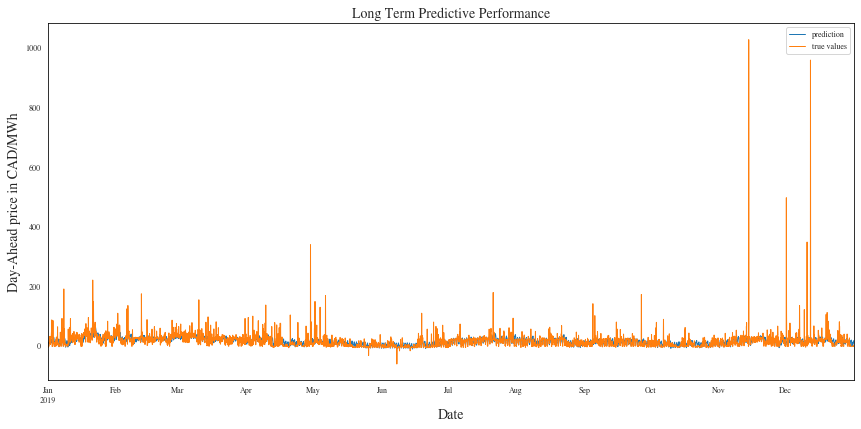

In [ ]:
f, ax = plt.subplots(figsize=(12, 6))
results.plot(ax=ax)
ax.set_ylabel('Day-Ahead price in CAD/MWh', fontsize=14)
ax.set_xlabel('Date', fontsize=14)
ax.set_title('Long Term Predictive Performance', fontsize=14);

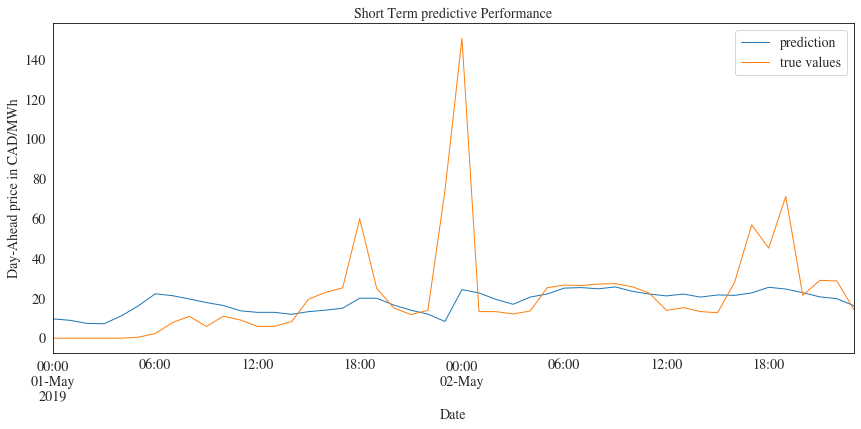

In [ ]:

f, ax = plt.subplots(figsize=(12, 6))
results.loc['2019-05':'2019-05-2'].plot(ax=ax,fontsize=14)
ax.set_ylabel('Day-Ahead price in CAD/MWh', fontsize=14)
ax.set_xlabel('Date', fontsize=14)
ax.set_title('Short Term predictive Performance', fontsize=14);
ax.legend(fontsize=14)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

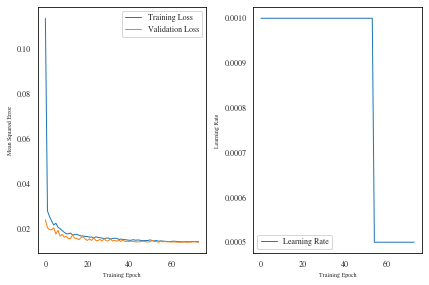

In [ ]:
f, (ax1,ax2) = plt.subplots(1,2)
ax1.plot(hist.history['loss'], label='Training Loss')
ax1.plot(hist.history['val_loss'], label='Validation Loss')

#ax1.set_ylim([0, 0.0150])
ax1.set_ylabel('Mean Squared Error')
ax1.set_xlabel('Training Epoch');
ax1.legend()

ax2.plot(hist.history['lr'],label='Learning Rate')
ax2.set_xlabel('Training Epoch')
ax2.set_ylabel('Learning Rate')
ax2.legend()
plt.savefig('HOEPTrainingLoss.png',dpi=300)
files.download('HOEPTrainingLoss.png')

In [ ]:
up=files.upload()

Saving ANNHOEP.csv to ANNHOEP.csv


In [ ]:
Ph1=pd.read_csv('ANNHOEP.csv',parse_dates=True,index_col=0)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

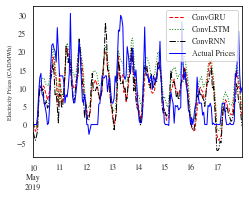

In [ ]:
Ph=Ph1
Ph['ConvGRU']['2019-05-10':'2019-05-17'].plot(ls='--',color='red',label='ConvGRU',figsize=(3.5,2.8))
Ph['ConvLSTM']['2019-05-10':'2019-05-17'].plot(ls=':',color='green',label='ConvLSTM',figsize=(3.5,2.8))
Ph['ConvRNN']['2019-5-10':'2019-05-17'].plot(ls='-.',color='black',label='ConvRNN',figsize=(3.5,2.8))
Ph['Actual Prices']['2019-05-10':'2019-05-17'].plot(color='blue',label='Actual Prices',figsize=(3.5,2.8))
plt.ylabel('Electricity Prices (CAD/MWh)')
plt.legend()
plt.savefig('HOEPANNForecasts.png',dpi=300)
files.download('HOEPANNForecasts.png')

In [ ]:
Ygru=Ph1['ConvGRU'].values.reshape(365,24)
Ylstm=Ph1['ConvLSTM'].values.reshape(365,24)
Yrnn=Ph1['ConvRNN'].values.reshape(365,24)
Yt=Ph1['Actual Prices'].values.reshape(365,24)
MAE_GRU=np.zeros(24)
MAE_LSTM=np.zeros(24)
MAE_RNN=np.zeros(24)

for i in range(24):
  MAE_GRU[i]=mean_absolute_error(Yt[:,i],Ygru[:,i])
  MAE_LSTM[i]=mean_absolute_error(Yt[:,i],Ylstm[:,i])
  MAE_RNN[i]=mean_absolute_error(Yt[:,i],Yrnn[:,i])

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

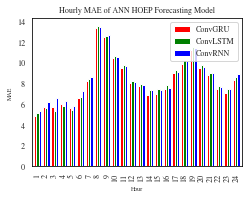

In [ ]:
hour=np.arange(1,25)
MAE_DF=pd.DataFrame({'Hour':hour,'ConvGRU':MAE_GRU,'ConvLSTM':MAE_LSTM,'ConvRNN':MAE_RNN})
MAE_DF.index=MAE_DF.Hour
MAE_DF.drop(columns='Hour',inplace=True)


MAE_DF.plot.bar(grid=False,color={'ConvGRU':'red','ConvLSTM':'green','ConvRNN':'blue'},figsize=(3.5,2.8),width=.8)
plt.title('Hourly MAE of ANN HOEP Forecasting Model')
plt.ylabel('MAE')

plt.savefig('ANNHOEPResults.pdf',dpi=300)
files.download('ANNHOEPResults.pdf')

**Adding More Features**

In the following we are going to add more features to the model in order to decrease the level of forecasting error.

In [ ]:
Features=features.values.reshape(len(features),timesteps,1)
Features.shape

(3645, 168, 1)

In [ ]:
Pred=model.predict(Features)
Y=da_scaler.inverse_transform(Pred.reshape(-1,1))

In [ ]:
Y=Y.flatten()

In [ ]:
DF=df.iloc[168:]
DF['Prediction']=Y

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


**Adding hour of the day, day of the week, and month of the year to the model**

In [ ]:
DF['Month']=DF.index.month
DF['Day']=DF.index.dayofweek
DF['Hour']=DF.index.hour
DF.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documen

,HOEP,Prediction,Month,Day,Hour
2010-01-08 00:00:00,30.08,31.570770,1,4,0
2010-01-08 01:00:00,30.08,27.087173,1,4,1
2010-01-08 02:00:00,29.98,25.042501,1,4,2
2010-01-08 03:00:00,29.71,24.092222,1,4,3
2010-01-08 04:00:00,29.72,23.866840,1,4,4


In [ ]:

#Y=df['2019'].values.reshape(365,24)
Y=DF['HOEP']
Y=Y.values.reshape(int(len(Y)/24),24)
DF['Returns Volatility']=Y.reshape(-1,1)
DF['Price Volatility']=0

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
Vol=np.zeros(24)
Vol_Price=Vol
for i in range(24):
  p=Y[:,i]
  p_bar=p.mean()
  z1=p-p_bar
  z2=np.sign(z1)
  rho_p=np.corrcoef(z1,z2)[0,1]
  t=np.abs(z1)/rho_p
  Vol_Price[i]=t.mean()
  r=p[1:]-p[:-1]
  r_bar=r.mean()
  x1=r-r_bar
  x2=np.sign(x1)
  rho=np.corrcoef(x1,x2)[0,1]
  s=np.abs(x1)/rho
  Vol[i]=s.mean()
  l1=len(s)
  l2=len(t)
  DF['Returns Volatility'].iloc[i*l1:(i+1)*l1]=s
  DF['Price Volatility'].iloc[i*l2:(i+1)*l2]=t

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [ ]:
DF

,HOEP,Prediction,Month,Day,Hour,H_Vol,Returns Volatility,Returns Volatility,Price Volatility
2010-01-08 00:00:00,30.08,31.570770,1,4,0,30.08,30.08,8.166751,20.794798
2010-01-08 01:00:00,30.08,27.087173,1,4,1,30.08,30.08,2.915773,27.316704
2010-01-08 02:00:00,29.98,25.042501,1,4,2,29.98,29.98,4.182887,24.971239
2010-01-08 03:00:00,29.71,24.092222,1,4,3,29.71,29.71,1.471847,21.611928
2010-01-08 04:00:00,29.72,23.866840,1,4,4,29.72,29.72,4.693515,22.777094
...,...,...,...,...,...,...,...,...,...
2019-12-31 19:00:00,0.00,15.908401,12,1,19,0.00,0.00,0.000000,1.770071
2019-12-31 20:00:00,0.00,12.820686,12,1,20,0.00,0.00,0.000000,4.910051
2019-12-31 21:00:00,-0.05,11.875637,12,1,21,-0.05,-0.05,-0.050000,21.437904
2019-12-31 22:00:00,-0.04,7.416037,12,1,22,-0.04,-0.04,-0.040000,27.202345


In [ ]:
volatility=np.zeros(int(len(df['2015':])))
l=len(df['2015':])/24
l=int(l)
for i in range(l):
  a=i*24
  b=(i+1)*24
  volatility[a:b]=Vol
len(volatility)


43824

In [ ]:
DF_prep=DF

In [ ]:
up=files.upload()

Saving Generation.csv to Generation.csv


In [ ]:
DF_Gen=pd.read_csv('Generation.csv')
DF_Gen.head()

,Date,Hour,NUCLEAR,GAS,HYDRO,WIND,SOLAR,BIOFUEL,Total Output
0,1/1/2015,1,11564,957,3173,2504,0.0,20,18218
1,1/1/2015,2,11560,946,3100,2262,0.0,20,17888
2,1/1/2015,3,11560,947,3051,2025,0.0,20,17603
3,1/1/2015,4,11444,949,3086,1950,0.0,22,17451
4,1/1/2015,5,11174,946,3131,2015,0.0,21,17287


In [ ]:
DF_Gen['WIND'].values

array([2504, 2262, 2025, ..., 1260, 1142, 1463])

In [ ]:
up=files.upload()

Saving Load.csv to Load.csv


In [ ]:
DF_Met=pd.read_csv('Load.csv')
DF_Met.index=pd.date_range('2015-01-01',periods=len(DF_Met),freq='H')
DF_Met.drop(columns='time',inplace=True)
DF_Met

,precipitation,temperature,irradiance_surface,irradiance_toa,snowfall,snow_mass,cloud_cover,air_density,Ontario Demand
2015-01-01 00:00:00,0.0106,-7.234,0.0000,0.0000,0.0106,2.8822,0.9042,1.3015,14960
2015-01-01 01:00:00,0.0087,-7.308,0.0000,0.0000,0.0087,2.8862,0.8513,1.3005,14476
2015-01-01 02:00:00,0.0083,-7.518,0.0000,0.0000,0.0083,2.8897,0.8154,1.3004,13979
2015-01-01 03:00:00,0.0095,-7.774,0.0000,0.0000,0.0095,2.8943,0.7639,1.3009,13670
2015-01-01 04:00:00,0.0103,-7.918,0.0000,0.0000,0.0103,2.9005,0.7003,1.3010,13567
...,...,...,...,...,...,...,...,...,...
2019-12-31 19:00:00,0.1723,-0.600,74.7493,393.6194,0.1477,7.3994,0.8581,1.2457,15909
2019-12-31 20:00:00,0.1430,-0.730,45.3361,236.8590,0.1181,7.5188,0.8028,1.2463,15198
2019-12-31 21:00:00,0.1234,-0.999,9.4692,52.2036,0.1065,7.6262,0.7567,1.2471,14678
2019-12-31 22:00:00,0.0986,-1.262,0.0079,0.0352,0.0839,7.7194,0.6732,1.2485,14136


In [ ]:
up=files.upload()

Saving Demand.csv to Demand.csv


In [ ]:
pd.read_csv('Demand.csv').columns

Index(['Date', 'Hour', 'Market Demand', 'Ontario Demand'], dtype='object')

In [ ]:
DF_Load=pd.read_csv('Demand.csv')
DF_Load.index=pd.date_range(start='2010-01-01',periods=len(DF_Load),freq='H')
DF_Load.drop(columns=['Date','Hour'],inplace=True)
DF_Load=DF_Load['2015':]
DF_Load.head()

,Market Demand,Ontario Demand
2015-01-01 00:00:00,18358,14960
2015-01-01 01:00:00,18012,14476
2015-01-01 02:00:00,17795,13979
2015-01-01 03:00:00,17559,13670
2015-01-01 04:00:00,17402,13567


**Adding day-ahead forecasts of renewable power plants generation as well as electricity demand to the model.**

In [ ]:
cols=DF_Met.columns
DF[cols]=DF_Met
DF=DF['2015':]
DF['Wind']=DF_Gen['WIND'].values
DF['Solar']=DF_Gen['SOLAR'].values
DF['Load']=DF_Load['Market Demand'].values
DF['Average Volatility']=volatility
DF.head()

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in

,HOEP,Prediction,Month,Day,Hour,H_Vol,Returns Volatility,Returns Volatility,Price Volatility,precipitation,temperature,irradiance_surface,irradiance_toa,snowfall,snow_mass,cloud_cover,air_density,Ontario Demand,Wind,Solar,Load,Average Volatility
2015-01-01 00:00:00,3.28,-0.573912,1,3,0,3.28,3.28,12.320235,37.671862,0.0106,-7.234,0.0,0.0,0.0106,2.8822,0.9042,1.3015,14960.0,2504,0.0,18358,21.889208
2015-01-01 01:00:00,0.00,-3.105544,1,3,1,0.00,0.00,0.253091,44.389161,0.0087,-7.308,0.0,0.0,0.0087,2.8862,0.8513,1.3005,14476.0,2262,0.0,18012,20.950494
2015-01-01 02:00:00,0.00,-1.568600,1,3,2,0.00,0.00,2.362836,44.389161,0.0083,-7.518,0.0,0.0,0.0083,2.8897,0.8154,1.3004,13979.0,2025,0.0,17795,20.232901
2015-01-01 03:00:00,0.00,-4.166168,1,3,3,0.00,0.00,2.404901,44.389161,0.0095,-7.774,0.0,0.0,0.0095,2.8943,0.7639,1.3009,13670.0,1950,0.0,17559,19.325505
2015-01-01 04:00:00,0.00,-3.559283,1,3,4,0.00,0.00,30.315152,49.340488,0.0103,-7.918,0.0,0.0,0.0103,2.9005,0.7003,1.3010,13567.0,2015,0.0,17402,18.104492


In [ ]:
DF.to_csv('XGBFeatures.csv')

NameError: ignored

In [ ]:
files.download('XGBFeatures.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# **Extreme Gradient Boosting Trees for Final Forecasts of Electricity Prices** 

In [ ]:
up=files.upload()


Saving XGBFeatures.csv to XGBFeatures.csv


In [ ]:
DF=pd.read_csv('XGBFeatures.csv',index_col=0,parse_dates=True)
DF.drop(columns=['H_Vol','Price Volatility'],inplace=True)

In [ ]:
import xgboost as xgb
from xgboost import plot_importance, plot_tree
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor

In [ ]:
DF_prep = replace_outliers(DF, 'HOEP', 1.7)
X=DF.drop(columns=['HOEP','Solar'])
Y=DF_prep['HOEP']
Y=pd.DataFrame(Y,index=DF.index)

In [ ]:
DF.head()

,HOEP,Prediction,Month,Day,Hour,Returns Volatility,precipitation,temperature,irradiance_surface,irradiance_toa,snowfall,snow_mass,cloud_cover,air_density,Ontario Demand,Wind,Solar,Load,Average Volatility,TES
2015-01-01 00:00:00,3.28,-0.573912,1,3,0,12.320235,0.0106,-7.234,0.0,0.0,0.0106,2.8822,0.9042,1.3015,14960,2504,0.0,18358,21.889208,4.086928
2015-01-01 01:00:00,0.00,-3.105544,1,3,1,0.253091,0.0087,-7.308,0.0,0.0,0.0087,2.8862,0.8513,1.3005,14476,2262,0.0,18012,20.950494,1.137845
2015-01-01 02:00:00,0.00,-1.568600,1,3,2,2.362836,0.0083,-7.518,0.0,0.0,0.0083,2.8897,0.8154,1.3004,13979,2025,0.0,17795,20.232901,0.530279
2015-01-01 03:00:00,0.00,-4.166168,1,3,3,2.404901,0.0095,-7.774,0.0,0.0,0.0095,2.8943,0.7639,1.3009,13670,1950,0.0,17559,19.325505,1.366963
2015-01-01 04:00:00,0.00,-3.559283,1,3,4,30.315152,0.0103,-7.918,0.0,0.0,0.0103,2.9005,0.7003,1.3010,13567,2015,0.0,17402,18.104492,2.798498


In [ ]:
X_Scaler=MinMaxScaler()
Xscaled=X_Scaler.fit_transform(X)
Temp=pd.DataFrame(Xscaled,columns=X.columns,index=X.index)
Xtrain=Temp['2015':'2018']
Xtest=Temp['2019']

Y_Scaler=MinMaxScaler()
Yscaled=Y_Scaler.fit_transform(Y.values.reshape(-1,1))
Y['Scaled HOEP']=Yscaled
Ytrain=Y['Scaled HOEP']['2015':'2018']
Ytest=DF['HOEP']['2019']

In [ ]:
print('MAE: ', mean_absolute_error(DF['TES']['2019'],Ytest))

print('RMSE: ', np.sqrt(mean_squared_error(DF['TES']['2019'],Ytest)))

print('R Squared: ', r2_score(DF['TES']['2019'],Ytest))

MAE:  9.350230516070777
RMSE:  21.621686168421203
R Squared:  -2.7685652586376395


In [ ]:
xgb1 = xgb.XGBRegressor()
parameters = { #when use hyperthread, xgboost may become slower
              'objective':['reg:linear'],
              'learning_rate': [.03, 0.05, .07], #so called `eta` value
              'max_depth': [5, 6, 7],
              'min_child_weight': [4],
              'silent': [1],
              'subsample': [0.7],
              'colsample_bytree': [0.7],
              'n_estimators': [100,500, 1000],
             'n_jobs' : [-1]}

xgb_grid = GridSearchCV(xgb1,
                        parameters,
                        cv = 5,
                        n_jobs = -1,
                        verbose=True)

xgb_grid.fit(Xtrain,Ytrain)

print(xgb_grid.best_score_)
print(xgb_grid.best_params_)

In [ ]:
#xgbbest = xgb.XGBRegressor(colsample_bytree= 0.7, learning_rate= 0.07, max_depth= 5, min_child_weight= 4, n_estimators= 100, n_jobs= -1, objective= 'reg:linear', silent= 1, subsample= 0.7) #Without Volatility and With Spikes
#xgbbest = xgb.XGBRegressor(colsample_bytree= 0.7, learning_rate= 0.05, max_depth= 5, min_child_weight= 4, n_estimators= 100, n_jobs= -1, objective= 'reg:linear', silent= 1, subsample= 0.7) #Without Volatility and Without Spikes
xgbbest = xgb.XGBRegressor(colsample_bytree= 0.45, learning_rate= 0.045, max_depth= 5, min_child_weight= 2, n_estimators= 150, n_jobs= -1, objective= 'reg:linear', silent= 1, subsample= 0.8) #With Volatility and Spikes. With Mean Volatility

xgbbest.fit(Xtrain,Ytrain)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.45, gamma=0,
             importance_type='gain', learning_rate=0.045, max_delta_step=0,
             max_depth=5, min_child_weight=2, missing=None, n_estimators=150,
             n_jobs=-1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None, silent=1,
             subsample=0.8, verbosity=1)

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor
gb=GradientBoostingRegressor(learning_rate=0.045,n_estimators=150,subsample=0.8,max_depth=5)
gb.fit(Xtrain,Ytrain)
Yscaled_Pred=gb.predict(Xtest)
Ypred=Y_Scaler.inverse_transform(Yscaled_Pred.reshape(-1,1))
print('MAE: ', mean_absolute_error(Ypred,Ytest))

print('RMSE: ', np.sqrt(mean_squared_error(Ypred,Ytest)))

print('R Squared: ', r2_score(Ypred,Ytest))

MAE:  7.170277028377792
RMSE:  20.048226571187733
R Squared:  -1.681347564692579


In [ ]:
Yscaled_Pred=xgbbest.predict(Xtest)
Ypred=Y_Scaler.inverse_transform(Yscaled_Pred.reshape(-1,1))
print('MAE: ', mean_absolute_error(Ypred,Ytest))

print('RMSE: ', np.sqrt(mean_squared_error(Ypred,Ytest)))

print('R Squared: ', r2_score(Ypred,Ytest))

MAE:  7.06610502827813
RMSE:  20.023493727436318
R Squared:  -1.8065697224025663


In [ ]:
HOEP_Scaled_XGB=xgbbest.predict(Temp)
HOEP_XGB=Y_Scaler.inverse_transform(HOEP_Scaled_XGB.reshape(-1,1))
DF['XGB']=HOEP_XGB
#DF.to_csv('PF_Input.csv')
#files.download('PF_Input.csv')

In [ ]:
Results=pd.DataFrame(Ytest)
Results['XGB Prediction']=Ypred
Results

,HOEP,XGB Prediction
2019-01-01 00:00:00,0.00,2.881031
2019-01-01 01:00:00,0.00,2.741079
2019-01-01 02:00:00,-0.11,2.422627
2019-01-01 03:00:00,-1.84,2.702404
2019-01-01 04:00:00,-0.47,2.498529
...,...,...
2019-12-31 19:00:00,0.00,5.715855
2019-12-31 20:00:00,0.00,5.512359
2019-12-31 21:00:00,-0.05,9.082147
2019-12-31 22:00:00,-0.04,6.849336


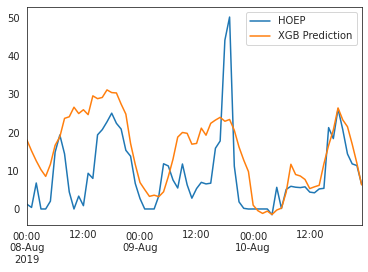

In [ ]:
Results['2019-08-08':'2019-08-10'].plot()

In [ ]:
Ytes=DF['TES']['2019'].values.reshape(365,24)
Ynn=DF['Prediction']['2019'].values.reshape(365,24)
Yt=Ytest.values.reshape(365,24)
Yp=Ypred.reshape(365,24)
MAE_Hourly_XGB=np.zeros(24)
MAE_Hourly_NN=np.zeros(24)
MAE_Hourly_TES=np.zeros(24)

for i in range(24):
  MAE_Hourly_XGB[i]=mean_absolute_error(Yt[:,i],Yp[:,i])
  MAE_Hourly_TES[i]=mean_absolute_error(Yt[:,i],Ytes[:,i])
  MAE_Hourly_NN[i]=mean_absolute_error(Yt[:,i],Ynn[:,i])


Text(0.5, 0, 'Hour')

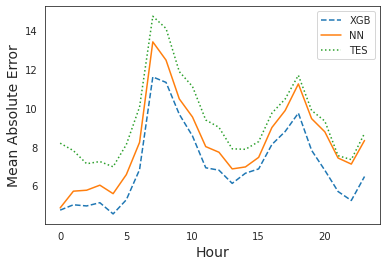

In [ ]:
plt.figsize=(12,10)
plt.plot(MAE_Hourly_XGB,ls='--',label='XGB')
plt.plot(MAE_Hourly_NN,ls='-',label='NN')
plt.plot(MAE_Hourly_TES,ls=':',label='TES')
plt.legend()
plt.ylabel('Mean Absolute Error',fontsize=14)
plt.xlabel('Hour',fontsize=14)

In [ ]:
hour=np.arange(1,25)
MAE_DF=pd.DataFrame({'Hour':hour,'XGB':MAE_Hourly_XGB,'ConvGRU':MAE_Hourly_NN,'TES':MAE_Hourly_TES})
MAE_DF.index=MAE_DF.Hour
MAE_DF.drop(columns='Hour',inplace=True)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

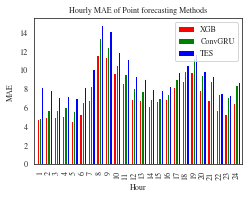

In [ ]:
#sns.set_style('dark')
MAE_DF.plot.bar(grid=False,color={'XGB':'red','ConvGRU':'green','TES':'blue'},figsize=(3.5,2.8),width=.8)
plt.title('Hourly MAE of Point forecasting Methods')
plt.rcParams['font.family']='STIXGeneral'
plt.rcParams['font.size']=8
plt.rcParams['figure.autolayout']=True
plt.rcParams['axes.titlesize']=8
plt.rcParams['axes.labelsize']=8
plt.rcParams['lines.linewidth']=1
plt.rcParams['lines.markersize']=2
plt.rcParams['legend.fontsize']=8
plt.rcParams['mathtext.fontset']='stix'
plt.rcParams['mathtext.fontset']='custom'
plt.rcParams['legend.numpoints']=1
plt.ylabel('MAE')

plt.savefig('PointForecasts.pdf',dpi=300)
files.download('PointForecasts.pdf')